In [1]:
import json
import os
from os import path as osp
import pandas as pd
import numpy as np
from PIL import Image
import re

In [2]:
split = 'dev'

# download annotations from here and put them in nlxgpt/data :
# https://drive.google.com/drive/folders/16sJjeEQE2o23G-GGUi870ubXzJjdRDua
# (cf. nlxgpt/README.md -> Annotations Download -> VQA-X link)

ann_dir = osp.abspath('../data/')
sample_dir = osp.abspath('../generated/')
img_dir = 'PATH'  # insert path to CLEVR images here (CLEVR_v1.0/images/)

# Preparation

## Read Annotations

In [3]:
def load_json(file): 
    with open(file, 'r') as f:
        data = json.load(f)
    return data

def get_confident_answers(list_of_answers): 
    return [x for x in list_of_answers if x['answer_confidence'] == 'yes']

def majority_vote(list_of_answers):
    answers = [a['answer'] for a in list_of_answers]
    return max(set(answers), key=answers.count)

In [4]:
with open(osp.join(ann_dir, f'CLEVRX_{split}.json')) as f:
    annotations = pd.DataFrame(json.load(f)['questions']).set_index('question_index')

## Read & Prepare Samples

In [5]:
def process_sample_file(filename):
    samples_df = pd.read_json(filename)
    
    # rename question id column & set as index
    samples_df = samples_df.rename(columns={'image_id': 'question_id'}).set_index('question_id')

    # split answers from predictions (and collect idx of entries where this doesn't work)
    samples_df['answers_explanations'] = samples_df.caption.map(lambda x: x.split(' because '))
    invalid_ids = samples_df[samples_df.answers_explanations.map(len) != 2].index
    # restrict to valid samples
    samples_df = samples_df[np.logical_not(samples_df.index.isin(invalid_ids))]

    # separate columns for answers and explanations
    samples_df['answer'] = samples_df.answers_explanations.map(lambda x: x[0])
    samples_df['explanation'] = samples_df.answers_explanations.map(lambda x: x[1])
    samples_df = samples_df.drop(columns=['answers_explanations'])
    
    return samples_df, invalid_ids.to_list()

def is_correct_answer(entry, annotations):
    answer = entry.answer
    question_id = entry.name
    # return true if predicted answer matches the annotation
    return answer == annotations.loc[question_id].answer

In [6]:
sample_fname = 'clevrx_unf_captions_full_2_val.json'
sample_file = osp.join(sample_dir, sample_fname)
samples_df, invalid_ids = process_sample_file(sample_file)

In [7]:
# determine correctness of predicted answers
samples_df['correct_answer'] = samples_df.apply(lambda x: is_correct_answer(x, annotations), axis=1)
print('clr acc:', round(sum(samples_df.correct_answer) / len(samples_df), 2))

clr acc: 0.83


# show examples

In [8]:
_anns = annotations.rename(columns={'answer': 'ann_answer', 'factual_explanation': 'ann_explanations'})[['question', 'image_filename', 'image_index', 'ann_answer', 'ann_explanations']]

examples = pd.merge(
    samples_df,
    _anns,
    left_index=True,
    right_index=True
)


In [9]:
def show_example(entry, base_img_dir=img_dir):
    img_fname = entry.image_filename
    split = re.search(r'CLEVR_([a-z]+)_\d+.png', img_fname).group(1)
    img_path = osp.join(base_img_dir, split, img_fname)

    print(f'Q {entry.name} / Image {entry.image_index} / {entry.image_filename}\n')
    
    display(Image.open(img_path))    
    
    # print entries
    print(entry.question, '\n')
    
    print('Predictions:')
    for c in ['answer', 'explanation', 'correct_answer']:
        print(f'\t{c.ljust(15)}\t{entry[c]}')
    print('\n')
    
    print(f'Ann.Answer\t{entry["ann_answer"]}')
    for i, exp in enumerate(entry["ann_explanations"]):
        print(f'Explanation {i+1}\t{exp}')
    
    print(f'\n{"="*25}\n')

Q 391274 / Image 39128 / CLEVR_train_039128.png



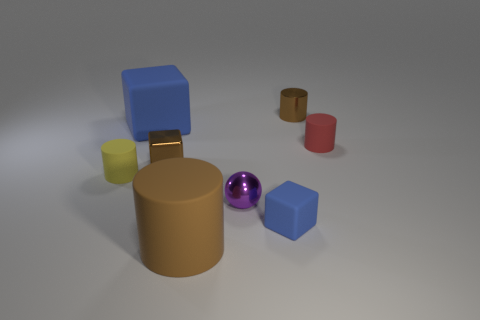

Is there a brown matte object that has the same shape as the yellow rubber thing? 

Predictions:
	answer         	yes
	explanation    	there is a brown matte cylinder which has the identical shape as a yellow rubber cylinder
	correct_answer 	True


Ann.Answer	yes
Explanation 1	There is the brown matte cylinder which has the identical shape as a yellow rubber cylinder.
Explanation 2	There is the brown matte cylinder that has the same shape as a yellow rubber cylinder.
Explanation 3	The brown matte cylinder has the same shape as a yellow rubber cylinder.


Q 520650 / Image 52066 / CLEVR_train_052066.png



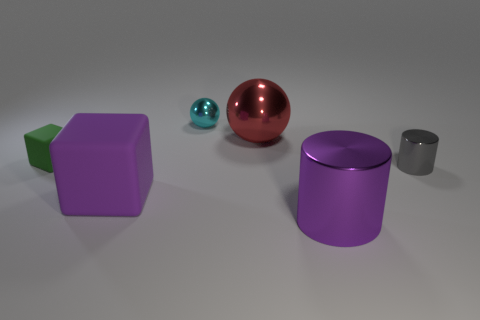

How many other objects are there of the same shape as the big purple metal object? 

Predictions:
	answer         	1
	explanation    	there is the cylinder which has the identical shape as a big purple metal cylinder
	correct_answer 	True


Ann.Answer	1
Explanation 1	There is a cylinder that has the same shape as a big purple metal cylinder.
Explanation 2	There is the cylinder that has the same shape as a big purple metal cylinder.
Explanation 3	There is the cylinder which has the identical shape as a big purple metal cylinder.
Explanation 4	There is a cylinder which has the identical shape as a big purple metal cylinder.
Explanation 5	The cylinder has the same shape as a big purple metal cylinder.


Q 76595 / Image 7659 / CLEVR_train_007659.png



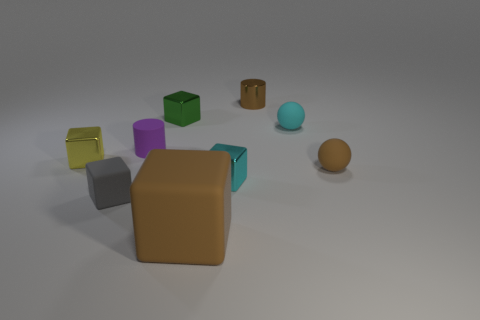

Are the small brown cylinder and the small gray block made of the same material? 

Predictions:
	answer         	no
	explanation    	the small brown cylinder is shiny and the small gray block is rubber
	correct_answer 	True


Ann.Answer	no
Explanation 1	The small brown cylinder is shiny and the small gray block is rubber.
Explanation 2	The small brown cylinder is metallic and the small gray block is matte.
Explanation 3	There is a small brown metal cylinder and there is a small gray matte block.
Explanation 4	There is a small brown shiny cylinder and there is a small gray matte block.
Explanation 5	The small brown cylinder is metallic and the small gray block is rubber.
Explanation 6	The small brown cylinder is shiny and the small gray block is matte.
Explanation 7	There is a small brown shiny cylinder and there is a small gray rubber block.
Explanation 8	The small brown cylinder is metal and the small gray block is matte.
Explanation 9	There is a small brown metallic cylinder and ther

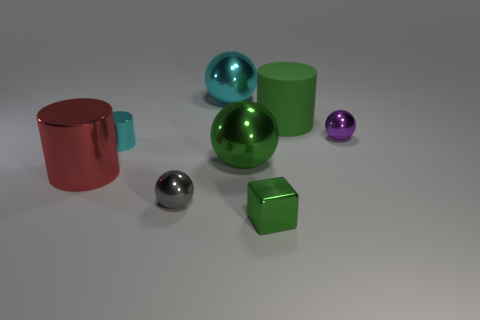

Are there any other things that have the same material as the large green cylinder? 

Predictions:
	answer         	no
	explanation    	there are no things which have the identical material as a large green cylinder
	correct_answer 	True


Ann.Answer	no
Explanation 1	No things have the same material as a large green cylinder.
Explanation 2	There are no things which have the identical material as a large green cylinder.
Explanation 3	There are no things that have the same material as a large green cylinder.


Q 302188 / Image 30219 / CLEVR_train_030219.png



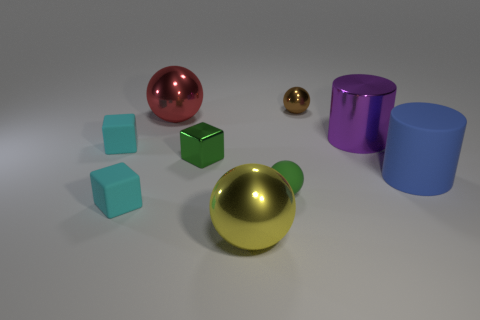

Is there a large metallic object that has the same shape as the tiny brown metallic object? 

Predictions:
	answer         	yes
	explanation    	there is the large metallic sphere that has the same shape as a tiny brown metallic sphere
	correct_answer 	True


Ann.Answer	yes
Explanation 1	Two large metallic spheres have the same shape as a tiny brown metallic sphere.
Explanation 2	There are two large metallic spheres which have the identical shape as a tiny brown metallic ball.
Explanation 3	There are two large metallic spheres that have the same shape as a tiny brown metallic sphere.
Explanation 4	Two large metallic spheres have the same shape as a tiny brown metallic ball.


Q 419353 / Image 41936 / CLEVR_train_041936.png



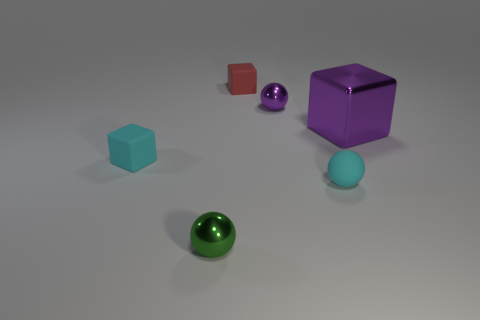

What size is the purple metallic block? 

Predictions:
	answer         	large
	explanation    	the purple metallic block is big
	correct_answer 	True


Ann.Answer	large
Explanation 1	The purple metallic block is large.
Explanation 2	There is a big purple metallic block.
Explanation 3	The purple metallic block is big.
Explanation 4	There is a large purple metallic block.


Q 171732 / Image 17174 / CLEVR_train_017174.png



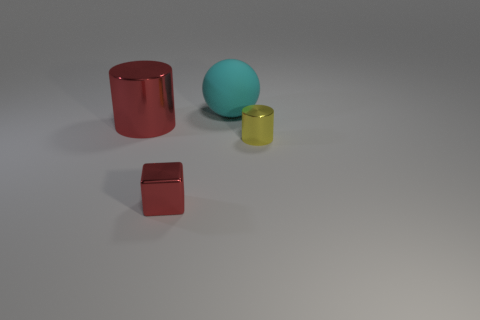

What number of objects are large objects that are left of the matte object or tiny matte blocks? 

Predictions:
	answer         	2
	explanation    	there are two large cylinders which are on the left side of the matte sphere
	correct_answer 	False


Ann.Answer	1
Explanation 1	There is a large cylinder that is left of the matte sphere.
Explanation 2	There is a large cylinder that is to the left of the matte sphere.
Explanation 3	There is a large cylinder which is on the left side of the matte sphere.


Q 416232 / Image 41624 / CLEVR_train_041624.png



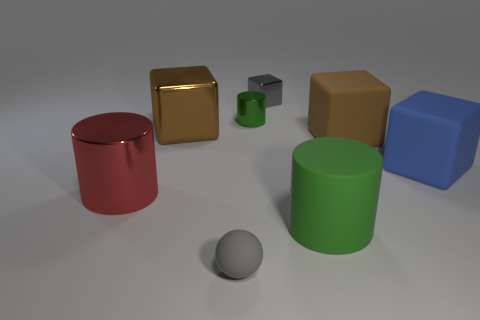

The large shiny cylinder is what color? 

Predictions:
	answer         	red
	explanation    	there is a large red shiny cylinder
	correct_answer 	True


Ann.Answer	red
Explanation 1	There is a large red shiny cylinder.
Explanation 2	The large shiny cylinder is red.


Q 265196 / Image 26520 / CLEVR_train_026520.png



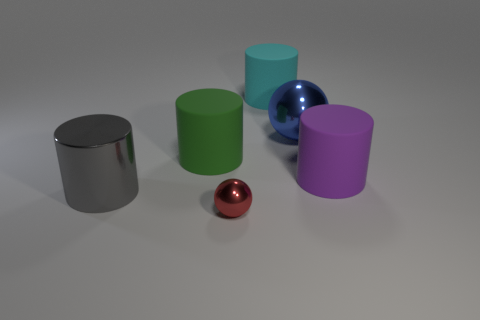

There is a object that is both in front of the blue metal thing and to the right of the large cyan thing; what is its size? 

Predictions:
	answer         	large
	explanation    	there is a large cylinder in front of the blue metal sphere and right of the large cyan
	correct_answer 	True


Ann.Answer	large
Explanation 1	There is a large cylinder in front of the blue metal sphere and right of the large cyan cylinder.
Explanation 2	There is a big cylinder in front of the blue metal ball and on the right side of the large cyan cylinder.


Q 453274 / Image 45328 / CLEVR_train_045328.png



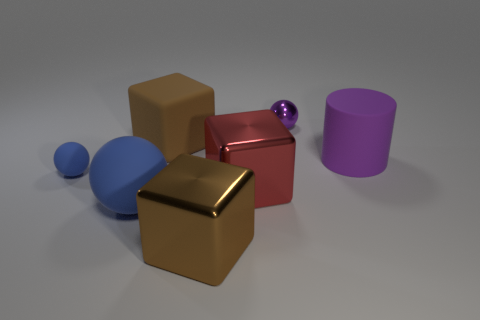

Are there any other cubes that have the same material as the large red block? 

Predictions:
	answer         	yes
	explanation    	there is the shiny cube which has the identical material as a large red block
	correct_answer 	True


Ann.Answer	yes
Explanation 1	There is the metal cube which has the identical material as a large red block.
Explanation 2	There is a shiny cube which has the identical material as a large red block.
Explanation 3	There is a metal cube that has the same material as a large red block.
Explanation 4	There is a metal cube which has the identical material as a large red block.
Explanation 5	There is the metal cube that has the same material as a large red block.
Explanation 6	There is a metallic cube which has the identical material as a large red block.
Explanation 7	The metallic cube has the same material as a large red block.
Explanation 8	There is a metallic cube that has the same material as a large red block.


Q 42749 / Image 4274 / CLEVR_train_004274.png

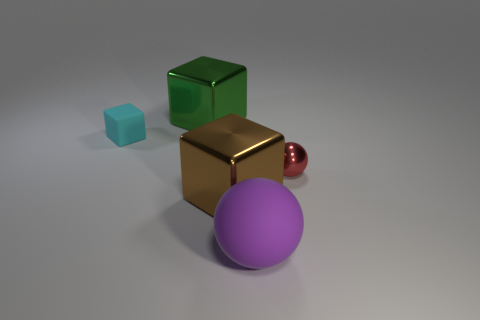

The object that is both on the right side of the large brown shiny object and on the left side of the tiny sphere is made of what material? 

Predictions:
	answer         	rubber
	explanation    	there is a matte cube right of the large brown shiny cube and left of the tiny sphere
	correct_answer 	True


Ann.Answer	rubber
Explanation 1	There is a matte ball on the right side of the large brown shiny block and on the left side of the tiny sphere.
Explanation 2	There is a rubber sphere right of the large brown shiny cube and left of the tiny sphere.
Explanation 3	There is a matte sphere to the right of the large brown shiny cube and to the left of the tiny sphere.
Explanation 4	There is a rubber sphere to the right of the large brown shiny cube and to the left of the tiny sphere.
Explanation 5	There is a matte sphere right of the large brown shiny cube and left of the tiny sphere.


Q 91361 / Image 9136 / CLEVR_train_009136.png



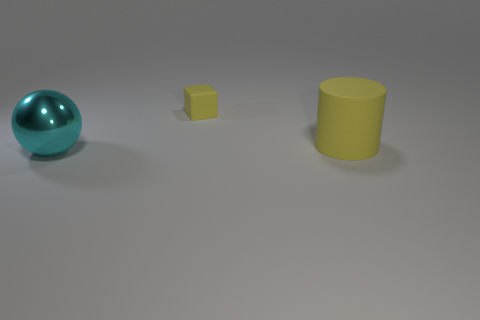

What shape is the other thing that is the same color as the big matte thing? 

Predictions:
	answer         	cube
	explanation    	there is the yellow block which has the identical color as a big matte cylinder
	correct_answer 	True


Ann.Answer	cube
Explanation 1	There is the yellow block which has the identical color as a big matte cylinder.
Explanation 2	The yellow cube has the same color as a big matte cylinder.
Explanation 3	There is the yellow cube that has the same color as a big matte cylinder.


Q 153543 / Image 15355 / CLEVR_train_015355.png



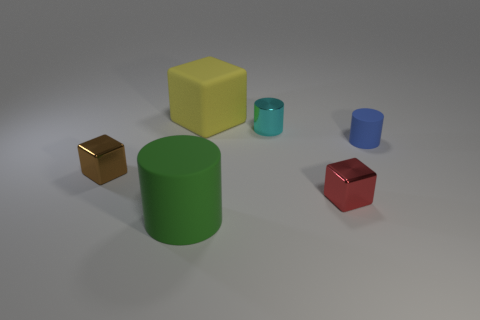

Are there any other things of the same color as the big rubber cylinder? 

Predictions:
	answer         	no
	explanation    	there are no things which have the identical color as a big rubber cylinder
	correct_answer 	True


Ann.Answer	no
Explanation 1	There are no things that have the same color as a big rubber cylinder.
Explanation 2	No things have the same color as a big rubber cylinder.
Explanation 3	There are no things which have the identical color as a big rubber cylinder.


Q 401865 / Image 40187 / CLEVR_train_040187.png



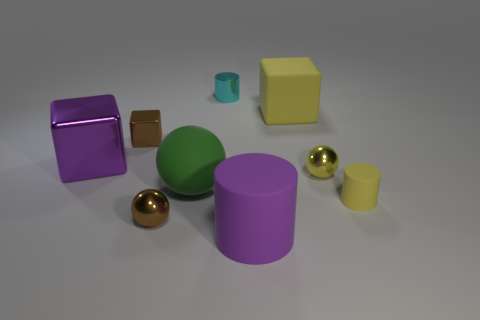

There is a shiny cylinder left of the purple matte cylinder; is its size the same as the cylinder to the right of the large purple cylinder? 

Predictions:
	answer         	no
	explanation    	the shiny cylinder left of the purple matte cylinder is small and the cylinder right of the large
	correct_answer 	False


Ann.Answer	yes
Explanation 1	The shiny cylinder on the left side of a purple matte cylinder is tiny and the cylinder to the right of a large purple cylinder is small.
Explanation 2	The shiny cylinder left of the purple matte cylinder is small and the cylinder right of the large purple cylinder is small.
Explanation 3	The shiny cylinder left of a purple matte cylinder is small and the cylinder right of a large purple cylinder is small.
Explanation 4	There is a tiny shiny cylinder which is on the left side of the purple matte cylinder and there is a small cylinder that is to the right of the large purple cylinder.
Explanation 5	There is a small shiny cylinder that is left of th

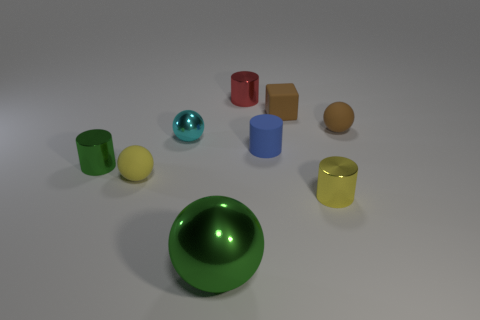

How many other objects are the same size as the red metallic cylinder? 

Predictions:
	answer         	6
	explanation    	there are three small spheres, two small cylinders and a small cube which have the identical size
	correct_answer 	False


Ann.Answer	7
Explanation 1	Three small spheres, three small cylinders and a small cube have the same size as a red metallic cylinder.
Explanation 2	There are three small spheres, three small cylinders and a small cube that have the same size as a red metallic cylinder.
Explanation 3	There are three small spheres, three small cylinders and a small cube which have the identical size as a red metallic cylinder.


Q 561339 / Image 56135 / CLEVR_train_056135.png



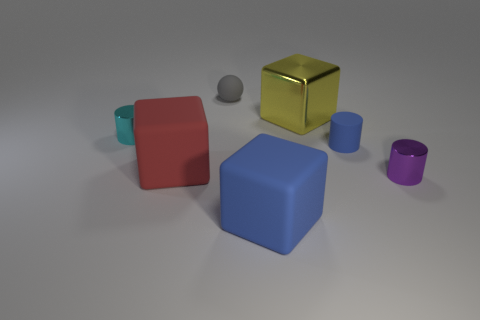

The block that is the same color as the small matte cylinder is what size? 

Predictions:
	answer         	large
	explanation    	there is the large blue block that has the same color as a small matte cylinder
	correct_answer 	True


Ann.Answer	large
Explanation 1	There is a big blue block which has the identical color as a small matte cylinder.
Explanation 2	There is a large blue block that has the same color as a small matte cylinder.
Explanation 3	The large blue block has the same color as a small matte cylinder.


Q 28993 / Image 2899 / CLEVR_train_002899.png



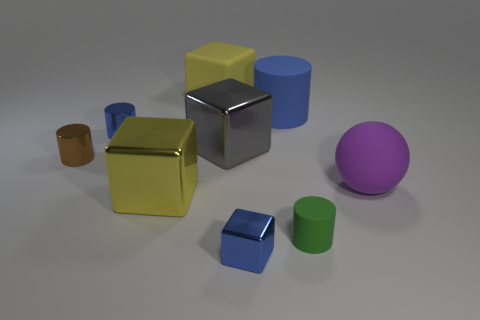

How many things are either gray balls or tiny green matte things? 

Predictions:
	answer         	1
	explanation    	there is a tiny green matte cylinder
	correct_answer 	True


Ann.Answer	1
Explanation 1	There is a tiny green matte cylinder.


Q 148735 / Image 14874 / CLEVR_train_014874.png



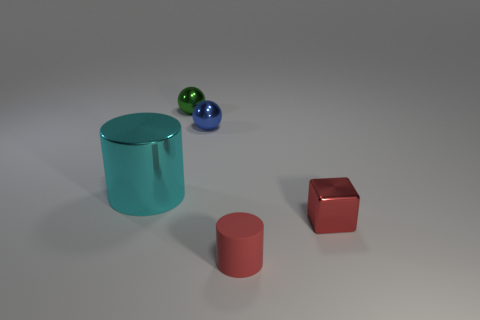

Is the cylinder that is in front of the big cylinder made of the same material as the small green sphere that is behind the tiny matte object? 

Predictions:
	answer         	no
	explanation    	there is a rubber cylinder which is in front of the big cylinder and there is a small
	correct_answer 	True


Ann.Answer	no
Explanation 1	There is a matte cylinder that is in front of the big cylinder and there is a small green shiny sphere which is behind the tiny matte cylinder.
Explanation 2	There is a matte cylinder that is in front of the big cylinder and there is a small green metal sphere that is behind the tiny matte cylinder.
Explanation 3	There is a rubber cylinder which is in front of the big cylinder and there is a small green shiny sphere which is behind the tiny matte cylinder.
Explanation 4	There is a rubber cylinder that is in front of the big cylinder and there is a small green metal sphere which is behind the tiny matte cylinder.
Explanation 5	There is a rubber cylinder which 

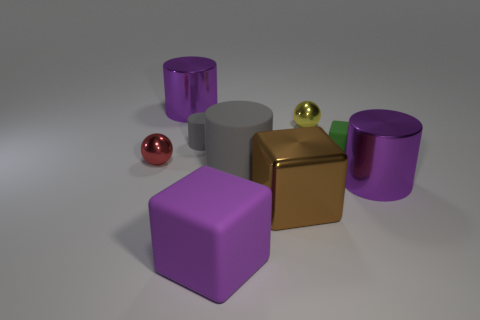

What number of other objects have the same material as the green thing? 

Predictions:
	answer         	3
	explanation    	there are two rubber cubes and a rubber cylinder that have the same material as a green cylinder
	correct_answer 	True


Ann.Answer	3
Explanation 1	Two rubber cylinders and a rubber cube have the same material as a green cube.
Explanation 2	There are two rubber cylinders and a rubber cube that have the same material as a green cube.
Explanation 3	Two rubber cylinders and a rubber cube have the same material as a green block.
Explanation 4	There are two rubber cylinders and a rubber cube which have the identical material as a green block.


Q 673733 / Image 67374 / CLEVR_train_067374.png



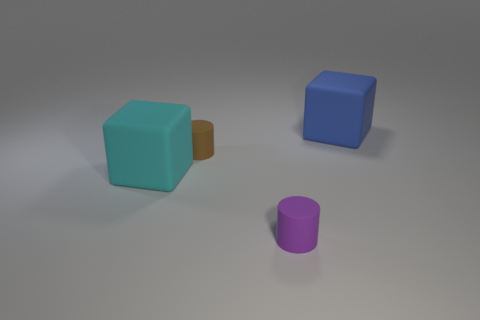

There is a brown cylinder that is the same size as the purple cylinder; what material is it? 

Predictions:
	answer         	rubber
	explanation    	there is the tiny brown matte cylinder which has the identical size as a purple cylinder
	correct_answer 	True


Ann.Answer	rubber
Explanation 1	There is a small brown rubber cylinder that has the same size as a purple cylinder.
Explanation 2	There is the small brown rubber cylinder that has the same size as a purple cylinder.
Explanation 3	There is the tiny brown matte cylinder which has the identical size as a purple cylinder.
Explanation 4	There is a tiny brown matte cylinder which has the identical size as a purple cylinder.
Explanation 5	The tiny brown matte cylinder has the same size as a purple cylinder.
Explanation 6	There is a tiny brown rubber cylinder which has the identical size as a purple cylinder.





In [10]:
examples.sample(20).apply(lambda x: show_example(x), axis=1)
print()